# Titanic Kaggle Challenge
### This is a Python notebook for the Titanic prediction challenge. The goal is to create a predictive model which tries to determine which passengers from an unknown list lost their lives in the tragic accident, based on information given about them.

## The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## The Data
The data in this challenge consists of information about various passenges on board the ship. Each line of the relevant .csv file contains information about a single passenger. This includes:

- PassengerId - unique identification number given to each passenger. This is relevant for submissions afterward.

- Survived - this is a binary variable denoting whether the passenger has survived or not. It is only present in the training dataset train.csv.

- Pclass - this is a variable taking one of three unique values (1, 2, or 3), denoting the ticket class for the passenger.

- Sex - this is a binary variable taking the values 'male' or 'female'
    
- Age - this is a numerical variable denoting the age of the passenger in years. Note that it may take fractional values.

- SibSp - this is a numerical variable denoting the number of siblings and spouses the passenger had with them on the ship. Siblings include (step-)brothers and (step-)sisters, and spouses include husbands and wives.

- Parch - this is a numerical variable denoting the number of parents and children the passenger had with them on the ship. Parents include a mother or father (without nannies), and children include (step-)sons and (step-)daughters.

- Ticket - this is a variable containing the ticker number (which may also include some combination of letters depending on the ticket type)

- Fare - this is the fare the passenger has paid to board the ship

- Cabin - this variable contains the cabin number of the passenger
    
- Embarked - this is a variable taking one of three unique values (C, Q, or S), denoting the port on which the passenger has embarked on the journey.

In [1]:
# import data in a pandas DataFrame
import pandas as pd
train_data = pd.read_csv('data/train.csv', header=0)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We should first check whether the data contains missing information, and remove the passengers for which this is the case.

In [7]:
for column in train_data.columns:
    print("Passengers with missing values for " + column + ":", train_data[column].isna().sum())

Passengers with missing values for PassengerId: 0
Passengers with missing values for Survived: 0
Passengers with missing values for Pclass: 0
Passengers with missing values for Name: 0
Passengers with missing values for Sex: 0
Passengers with missing values for Age: 177
Passengers with missing values for SibSp: 0
Passengers with missing values for Parch: 0
Passengers with missing values for Ticket: 0
Passengers with missing values for Fare: 0
Passengers with missing values for Cabin: 687
Passengers with missing values for Embarked: 2


There appears to be missing values for the Age, Cabin, and Embarked variables. Hence, if any of these are used in out model we should remove them.

In the example submission for this competition it is assumed that whether the passenger has survived is entirely determined by their gender. Specifically, the prediction is that all female passengers have survived. Below we find what percentage of the female and male passengers in the training data did survive.

In [2]:
women_data = train_data.loc[train_data.Sex == 'female']
men_data = train_data.loc[train_data.Sex == 'male']
survival_rate_women = sum(women_data['Survived'])/len(women_data)
survival_rate_men = sum(men_data['Survived'])/len(men_data)
print("Percentage of men who survived:", round(survival_rate_men*100, 2))
print("Percentage of women who survived:", round(survival_rate_women*100, 2))

Percentage of men who survived: 18.89
Percentage of women who survived: 74.2


We see that there is a significant difference between the survival rates for women and men, so the initial approach is quite reasonable. However, such an approach makes use of only one of the available data columns, so there is likely much room for improvement.

To build on this initial model we consider building a random forest. This is an ensemble model consisting of several decision trees. A decision tree contains a series of nodes which split the resepective data entry into one of two branches depending on some condition. At the end of the branch lies the prediction the tree would make for the outcome of the passenger. As an example, out initial model consisted of a single node whose condition was whether the passenger was female or male. In the former case it predicted that the passenger survived, and the opposite for the latter.

A decision tree is specified by its depth, or alternatively by a minimum sample split size. The depth determines the number of splits in the data that occur along a longest branch. The minimum sample split size is the minimum number of samples required to perform a split depending on some condition.

A random forest is an ensemble of multiple trees with some specified depth or minimum sample size. Usually a set of predictors is decided upon in advance, and for each tree in the forest, a random predictor is used to condition the samples at the current node.

Let us build a random forest for this data set. We have to decide which predictors to use in the decision trees. Considering the data and the available variables, reasonable choices include:
- Pclass - the class of the ticker likely determines the priority with whcich the passengers were evacuated
- Sex - we saw that the gender of the passengers shows good predictive power
- Parch - passengers with children will likely gain priority for evacuation
- Age - older passengers will likely also be saved first (note that there are missing values for this predictor which should be removed)
- SibSp - it is likely that if you have a sibling or spouse that has been put on an evacuation boat, you will also be put on that boat. So there is perhaps some correlation between this variable and having survived.

On the other hand, variables which at first glance may not have much predictive power include:
- Name
- Ticket
- Cabin
- Fare - this may be relevant but it is likely highly correlated with the ticket class, while also less informative.
- Embarked - this likely does not have any influence as the accident has nothing to do with where the passengers embarked.

In [32]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_score(features, train_data, max_depth = 5, n_estimators = 100):

    reduced_data = train_data[features + ['Survived']]

    # remove missing values from data
    for column in features:
        if reduced_data[column].isna().sum() > 0:
            reduced_data.dropna(inplace=True)
            break

    X = pd.get_dummies(reduced_data[features])
    y = reduced_data['Survived']

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth = max_depth, random_state=1)
    model.fit(X, y)

    return model.score(X, y) * 100

In [33]:
features = ['Pclass', 'Sex', 'Parch', 'Age', 'SibSp']
print('Accuracy (with age):', round(random_forest_score(features, train_data), 2), '%')
features = ['Pclass', 'Sex', 'Parch', 'SibSp']
print('Accuracy (without age):', round(random_forest_score(features, train_data), 2), '%')

Accuracy (with age): 84.59 %
Accuracy (without age): 81.48 %


/var/folders/kd/p2pqbh9n41d6x0bm8p7p9dd00000gn/T/ipykernel_43114/2296993370.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_data.dropna(inplace=True)


The model we built above achieves a score of $84.59\%$. This is better than a model which does not include the age as a predictor, despite the fact that it would include more data (the Age predictor contains missing information).

However, it is important to note that we are testing the model on the training data set, so it is possible that it is overfitting. Instead, it is better to split the training data into a couple of sets and cross-validate the models. Once we do this, we can further fine tune the parameters of our random forest, for instance the maximum depth and the number of trees.

In [78]:
from sklearn.model_selection import cross_val_score
import numpy as np

def create_X_y_sets(data, features, indicator_column=None):
    """
    Returns the X and y datasets to be used to train a model,
    based on the passed feature set. It assigns dummy variables
    to the appropriate columns in X.
    """

    if indicator_column == None:
        reduced_data = data[features]
    else:
        reduced_data = data[features + [indicator_column]]

    # remove missing values from data
    for column in features:
        if reduced_data[column].isna().sum() > 0:
            reduced_data.dropna(inplace=True)
            break

    X = pd.get_dummies(reduced_data[features], drop_first=True)
    if indicator_column != None:
        y = reduced_data[indicator_column]
        return X, y

    return X

def create_random_forest_model(n_estimators, max_depth):

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=1)
    return model

def cross_validation_accuracy(model, X, y, no_folds):

    scores = cross_val_score(model, X, y, cv=no_folds, scoring='accuracy')
    return np.average(scores) * 100

In [65]:
indicator_column = 'Survived'
features = ['Pclass', 'Sex', 'Parch', 'Age', 'SibSp']
X_age, y_age = create_X_y_sets(train_data, features, indicator_column)
features = ['Pclass', 'Sex', 'Parch', 'SibSp']
X_no_age, y_no_age = create_X_y_sets(train_data, features, indicator_column)
model = create_random_forest_model(100, 5)
no_folds = 10

print("With age:", cross_validation_accuracy(model, X_age, y_age, no_folds), '%')
print("Without age:", cross_validation_accuracy(model, X_no_age, y_no_age, no_folds), '%')

/var/folders/kd/p2pqbh9n41d6x0bm8p7p9dd00000gn/T/ipykernel_43114/2120722132.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_data.dropna(inplace=True)


With age: 81.9385758998435
Without age: 78.56679151061174


We see that the cross-validation score is slightly lower than waht we found when evaulating our model on the full training data, indicating there was likely some bias. Hence, this is a better way to quantify the results of the model. Note that we still find that including age results in a better model, so we will keep using it.

Now, it is a good idea to tune the parameters of the model by analysing how its accuracy varies when changing them

In [74]:
no_folds = 10
no_estimators_values = [10, 25, 50, 100, 150, 200, 300, 400, 500]
max_depth_values = [i+1 for i in range(10)]
accuracies = np.empty(shape=(len(no_estimators_values), len(max_depth_values)))
max_accuracy = 0
for index_1, n_estimators in enumerate(no_estimators_values):
    for index_2, max_depth in enumerate(max_depth_values):
        print('Training random forest with ' + str(n_estimators) + ' trees with a maximum depth of ' + str(max_depth) + '...')
        tmp_model = create_random_forest_model(n_estimators, max_depth)
        tmp_accuracy = cross_validation_accuracy(tmp_model, X_age, y_age, no_folds)
        print("\tAccuracy of " + str(round(tmp_accuracy, 2)) + "% achieved!")
        if tmp_accuracy > max_accuracy:
            best_model = str(n_estimators) + "_trees_depth_" + str(max_depth)
            max_accuracy = tmp_accuracy
        accuracies[index_1, index_2] = tmp_accuracy

Training random forest with 10 trees with a maximum depth of 1...
	Accuracy of 78.0% achieved!
Training random forest with 10 trees with a maximum depth of 2...
	Accuracy of 78.71% achieved!
Training random forest with 10 trees with a maximum depth of 3...
	Accuracy of 79.42% achieved!
Training random forest with 10 trees with a maximum depth of 4...
	Accuracy of 80.25% achieved!
Training random forest with 10 trees with a maximum depth of 5...
	Accuracy of 80.4% achieved!
Training random forest with 10 trees with a maximum depth of 6...
	Accuracy of 81.1% achieved!
Training random forest with 10 trees with a maximum depth of 7...
	Accuracy of 80.54% achieved!
Training random forest with 10 trees with a maximum depth of 8...
	Accuracy of 81.94% achieved!
Training random forest with 10 trees with a maximum depth of 9...
	Accuracy of 80.54% achieved!
Training random forest with 10 trees with a maximum depth of 10...
	Accuracy of 80.68% achieved!
Training random forest with 25 trees with 

The best model is: 400_trees_depth_7 with an accuracy of  82.64671361502349 percent.


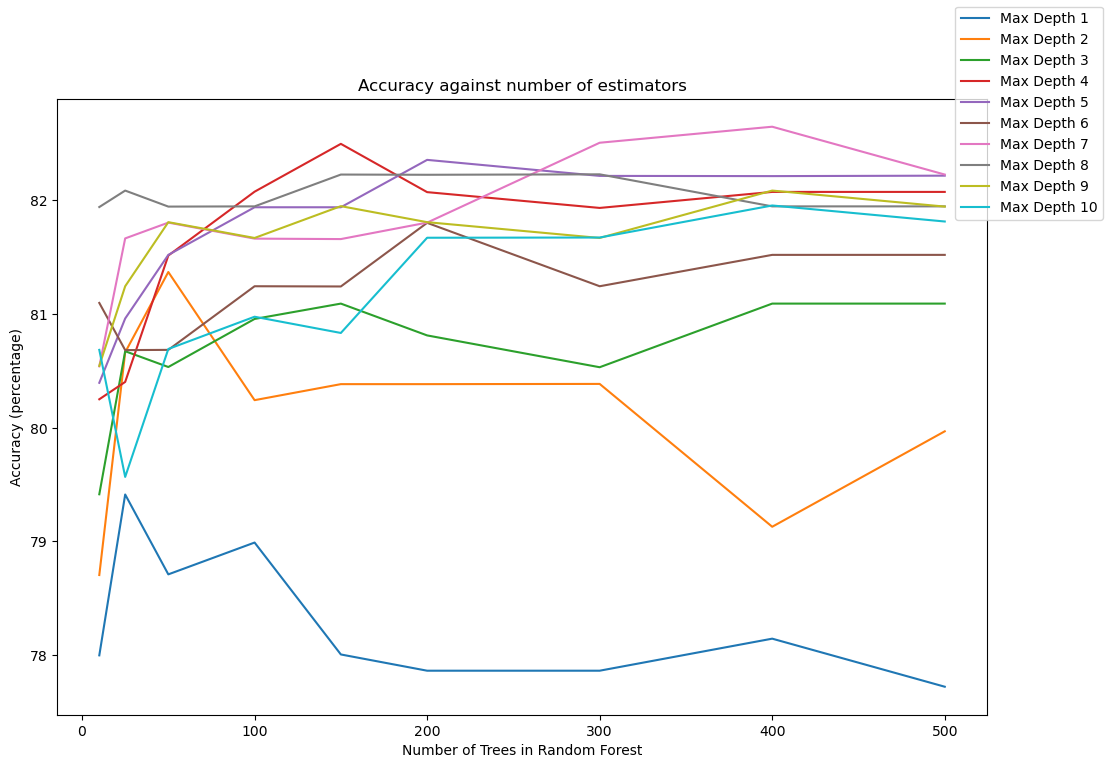

In [75]:
print('The best model is:', best_model, 'with an accuracy of ', max_accuracy, 'percent.')
# plot the data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12, 8))
for index, max_depth in enumerate(max_depth_values):

    ax.plot(no_estimators_values, accuracies[:, index], label='Max Depth ' + str(max_depth))

ax.set_xlabel('Number of Trees in Random Forest')
ax.set_ylabel('Accuracy (percentage)')
ax.set_title('Accuracy against number of estimators')
fig.legend()

From the analysis above it seems that the larger the depth, the better the model, although the ebenfit dimishes after a certain point. The best model is supposedly the one with 400 trees and a maximum depth of 7. This is what we will use to train the model on the full data set, and form predictions for the testing data set.

In [77]:
model_final = create_random_forest_model(400, 7)
model_final.fit(X_age, y_age)
print('Final Model accuracy: ' + str(round(model_final.score(X_age, y_age)*100, 2)) + '%')

Final Model accuracy: 88.94%


In [82]:
test_data = pd.read_csv('data/test.csv')
for column in test_data.columns:
    print("Passengers with missing values for " + column + ":", test_data[column].isna().sum())

Passengers with missing values for PassengerId: 0
Passengers with missing values for Pclass: 0
Passengers with missing values for Name: 0
Passengers with missing values for Sex: 0
Passengers with missing values for Age: 86
Passengers with missing values for SibSp: 0
Passengers with missing values for Parch: 0
Passengers with missing values for Ticket: 0
Passengers with missing values for Fare: 1
Passengers with missing values for Cabin: 327
Passengers with missing values for Embarked: 0


Note that even in the test data there are passengers which have missing information about their age. To deal with this amd still form predictions for such passengers, we also build the best model when we don't the age predictor.

[[4.99006302e-322 0.00000000e+000 2.22809558e-312 1.76125651e-312
  5.53353523e-322]]


In [93]:
no_folds = 10
no_estimators_values = [10, 25, 50, 100, 150, 200, 300, 400, 500, 600, 700]
max_depth_values = [i+1 for i in range(10)]
accuracies_no_age = np.empty(shape=(len(no_estimators_values), len(max_depth_values)))
max_accuracy_no_age = 0
for index_1, n_estimators in enumerate(no_estimators_values):
    for index_2, max_depth in enumerate(max_depth_values):
        print('Training random forest with ' + str(n_estimators) + ' trees with a maximum depth of ' + str(max_depth) + '...')
        tmp_model = create_random_forest_model(n_estimators, max_depth)
        tmp_accuracy = cross_validation_accuracy(tmp_model, X_no_age, y_no_age, no_folds)
        print("\tAccuracy of " + str(round(tmp_accuracy, 2)) + "% achieved!")
        if tmp_accuracy > max_accuracy_no_age:
            best_model_no_age = str(n_estimators) + "_trees_depth_" + str(max_depth)
            max_accuracy_no_age = tmp_accuracy
        accuracies_no_age[index_1, index_2] = tmp_accuracy

Training random forest with 10 trees with a maximum depth of 1...
	Accuracy of 77.12% achieved!
Training random forest with 10 trees with a maximum depth of 2...
	Accuracy of 77.45% achieved!
Training random forest with 10 trees with a maximum depth of 3...
	Accuracy of 78.12% achieved!
Training random forest with 10 trees with a maximum depth of 4...
	Accuracy of 79.02% achieved!
Training random forest with 10 trees with a maximum depth of 5...
	Accuracy of 78.46% achieved!
Training random forest with 10 trees with a maximum depth of 6...
	Accuracy of 78.23% achieved!
Training random forest with 10 trees with a maximum depth of 7...
	Accuracy of 78.46% achieved!
Training random forest with 10 trees with a maximum depth of 8...
	Accuracy of 78.46% achieved!
Training random forest with 10 trees with a maximum depth of 9...
	Accuracy of 78.57% achieved!
Training random forest with 10 trees with a maximum depth of 10...
	Accuracy of 78.57% achieved!
Training random forest with 25 trees wi

The best model is: 600_trees_depth_3 with an accuracy of  80.58426966292134 percent.


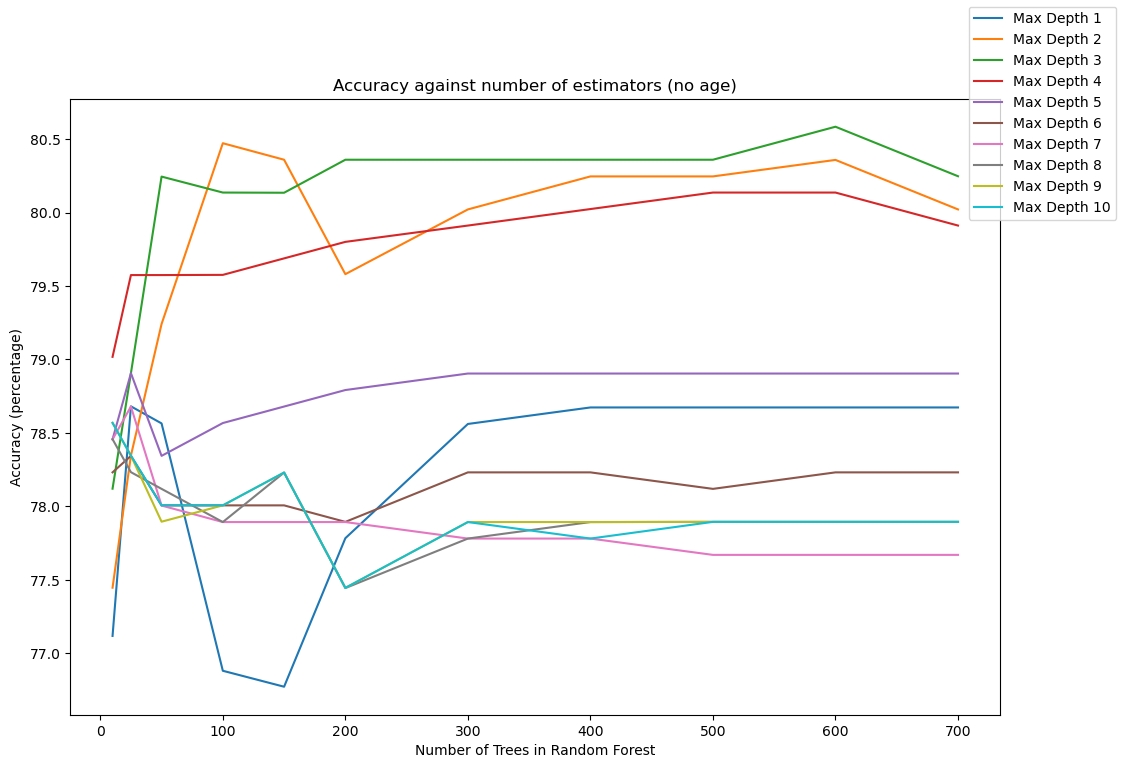

In [95]:
print('The best model is:', best_model_no_age, 'with an accuracy of ', max_accuracy_no_age, 'percent.')
# plot the data
import matplotlib.pyplot as plt
fig_no_age, ax_no_age = plt.subplots(figsize = (12, 8))
for index, max_depth in enumerate(max_depth_values):

    ax_no_age.plot(no_estimators_values, accuracies_no_age[:, index], label='Max Depth ' + str(max_depth))

ax_no_age.set_xlabel('Number of Trees in Random Forest')
ax_no_age.set_ylabel('Accuracy (percentage)')
ax_no_age.set_title('Accuracy against number of estimators (no age)')
fig_no_age.legend()

In [96]:
model_final_no_age = create_random_forest_model(600, 3)
model_final_no_age.fit(X_no_age, y_no_age)
print('Final Model (no age) accuracy: ' + str(round(model_final_no_age.score(X_no_age, y_no_age)*100, 2)) + '%')

Final Model (no age) accuracy: 80.92%


In [100]:
# create submission
features_age = ['Pclass', 'Sex', 'Parch', 'Age', 'SibSp']
features_no_age = ['Pclass', 'Sex', 'Parch', 'SibSp']
X_test_age = create_X_y_sets(test_data, features_age)
predictions_age = model_final.predict(X_test_age)
X_test_no_age = pd.get_dummies(test_data[test_data['Age'].isnull()][features_no_age], drop_first=True)
predictions_no_age = model_final_no_age.predict(X_test_no_age)

/var/folders/kd/p2pqbh9n41d6x0bm8p7p9dd00000gn/T/ipykernel_43114/3535805926.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_data.dropna(inplace=True)


In [105]:
passenger_ids = test_data[test_data['Age'].notnull()].PassengerId.to_list() + test_data[test_data['Age'].isnull()].PassengerId.to_list()
predictions = list(predictions_age) + list(predictions_no_age)
output = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

Overall, this model achieved a score of $76.32\%$ on the test data set according to Kaggle.